# Step 4. Flower Classifier - Convolutional Neural Network

This approach is better suited than pure Artificial Neural Network (ANN) because it is able to reliably capture important features in a 2D image.

Optimizer: `tf.keras.optimizers.RMSprop`

According to [Tensorflow API docs](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/RMSprop), The gist of RMSprop is to:

- Maintain a moving (discounted) average of the square of gradients
- Divide the gradient by the root of this average

Thus, this is a good choice for non-stationery problems. From observing our baseline ANN model that uses Adam optimizer and its prediction on the test dataset, we saw that the baseline model struggles to capture our non-stationary data: there is significant variance in lighting, angle, zoom level, etc. As such, RMSprop is a better choice than Adam.

Since our data is balanced, the metric we are using to evaluate its performance is **Accuracy** ($Accuracy = \frac{correct \; classifications}{all \; classifications}$), more specifically its [Tensorflow's CategoricalAccuracy Implementation](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/CategoricalAccuracy).

Refer to the code below to see how it is set up, trained, and evaluated.

In [1]:
# Imports and environmental setups

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop


# Custom utils functions
from utils import dataset
from utils.visualization import plot_learning_curve
from utils.visualization import visualize_16predictions
from utils.glob import TARGET_IMG_SIZE


# Reproducible results
np.random.seed(42)
tf.random.set_seed(42)

# Misc.
import os

plt.style.use('ggplot')
model_name = 'clf-cnn'
dir_raw_dataset = os.path.join('..', 'data', 'data')
dir_train_dataset = os.path.join('..', 'data', 'train')
dir_test_dataset = os.path.join('..', 'data', 'test')
dir_log = os.path.join('..', 'log', model_name)
dir_models = os.path.join('..', 'models')
path_model = os.path.join(dir_models, model_name + '.h5')


# Environment information
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
GPU is NOT AVAILABLE


## 4.1. Load Dataset

In [2]:
df = dataset.load(dir_train_dataset)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13073 entries, 0 to 13072
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ImgPath       13073 non-null  object 
 1   FileType      13073 non-null  object 
 2   Width         13073 non-null  int64  
 3   Height        13073 non-null  int64  
 4   Ratio         13073 non-null  float64
 5   Mode          13073 non-null  object 
 6   Bands         13073 non-null  object 
 7   Transparency  13073 non-null  bool   
 8   Animated      13073 non-null  bool   
 9   Class         13073 non-null  object 
dtypes: bool(2), float64(1), int64(2), object(5)
memory usage: 842.7+ KB


In [4]:
df.sample(n=42, random_state=42)

,ImgPath,FileType,Width,Height,Ratio,Mode,Bands,Transparency,Animated,Class
10022,Rosy/000274.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Rosy
11756,Tana/000414.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Tana
12394,Tana/001211.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Tana
11387,Rosy/rosy_60.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Rosy
7551,Lisianthus/lisianthus_247.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Lisianthus
6202,Hydrangeas/hydrangeas_187.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Hydrangeas
5714,Hydrangeas/001008.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Hydrangeas
7990,Lisianthus/lisianthus_761.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Lisianthus
12896,Tana/tana_458.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Tana
3288,Chrysanthemum/000005.jpg,jpg,256,256,1.0,RGB,R G B,False,False,Chrysanthemum


In [5]:
train, val = train_test_split(df, shuffle=True, test_size=0.25, random_state=42)  # 80/20/20 - train/val/test

print(f'Train data: {train.shape[0]} samples, Validation Data: {val.shape[0]} samples.')

Train data: 9804 samples, Validation Data: 3269 samples.


## 4.2. Model Setup and Training

### 4.2.1. Hyper-parameters

In [6]:
# Model Parameters
BATCH_SIZE = 512
INPUT_DIM = (TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3)  # RGB - 3 channels images
OUTPUT_CLASSES = 8  # One-hot encoded: 8 different classes

# Training Parameters
EPOCHS = 32
LEARNING_RATE = 1e-3
MOMENTUM = 0.9

### 4.2.2. Model Architecture

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(4, (4, 4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(8, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=21),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=42),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
], name=model_name)

model.compile(
    optimizer=RMSprop(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['categorical_accuracy'],
)

In [8]:
model.summary()

Model: "clf-cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 4)       196       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 8)       520       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 16)        2064      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 16)       0   

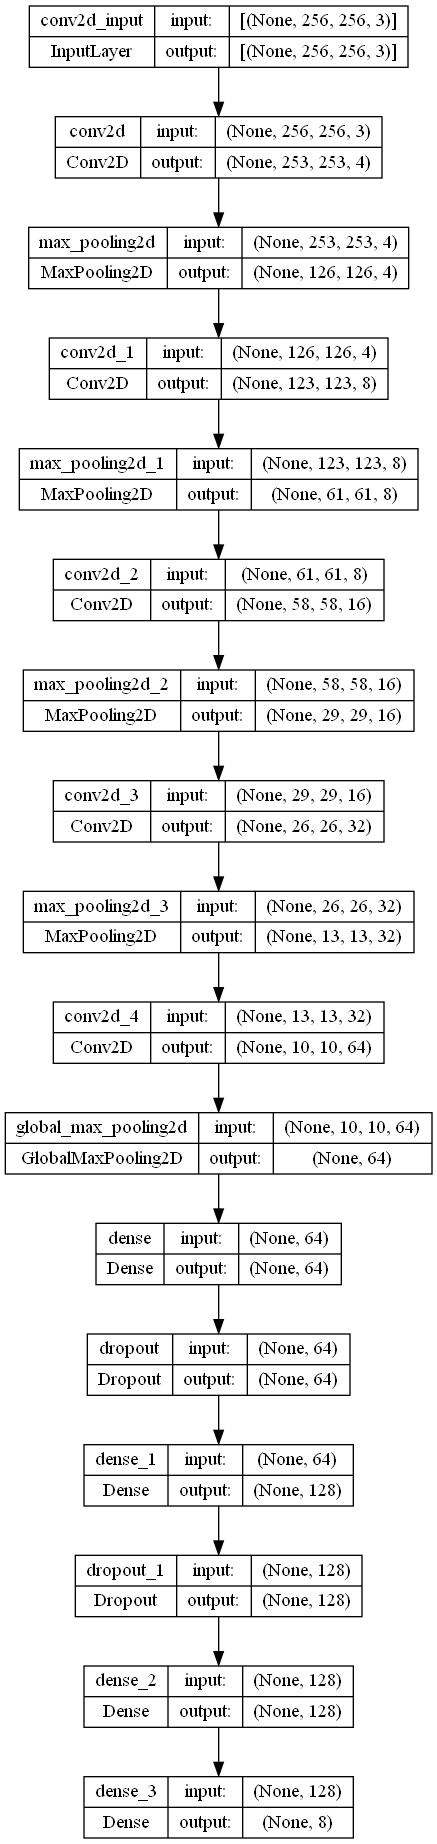

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True, to_file=f'images/{model_name}-Diagram.png')

### 4.2.3. Training

In [10]:
train['Class'] = train['Class'].astype('str')
train_datagen = ImageDataGenerator(data_format='channels_last')
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=dir_train_dataset,
    x_col='ImgPath',
    y_col='Class',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val['Class'] = val['Class'].astype('str')
val_datagen = ImageDataGenerator(data_format='channels_last')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory=dir_train_dataset,
    x_col='ImgPath',
    y_col='Class',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

Found 9804 validated image filenames belonging to 8 classes.
Found 3269 validated image filenames belonging to 8 classes.


In [11]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=dir_log, write_graph=False)
history = model.fit(
    train_generator, validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train.shape[0] // BATCH_SIZE,
    validation_steps=val.shape[0] // BATCH_SIZE,
    verbose=1, callbacks=[tensorboard_callback],
)

Epoch 1/32
19/19 [==============================] - 101s 5s/step - loss: 2.2383 - categorical_accuracy: 0.1152 - val_loss: 2.1346 - val_categorical_accuracy: 0.1341
Epoch 2/32
19/19 [==============================] - 106s 6s/step - loss: 2.1413 - categorical_accuracy: 0.1207 - val_loss: 2.1437 - val_categorical_accuracy: 0.1198
Epoch 3/32
19/19 [==============================] - 97s 5s/step - loss: 2.1233 - categorical_accuracy: 0.1254 - val_loss: 2.1038 - val_categorical_accuracy: 0.1208
Epoch 4/32
19/19 [==============================] - 125s 7s/step - loss: 2.1071 - categorical_accuracy: 0.1232 - val_loss: 2.0901 - val_categorical_accuracy: 0.1234
Epoch 5/32
19/19 [==============================] - 106s 6s/step - loss: 2.1023 - categorical_accuracy: 0.1176 - val_loss: 2.0996 - val_categorical_accuracy: 0.1217
Epoch 6/32
19/19 [==============================] - 100s 5s/step - loss: 2.1038 - categorical_accuracy: 0.1150 - val_loss: 2.1014 - val_categorical_accuracy: 0.1182
Epoch 7/32


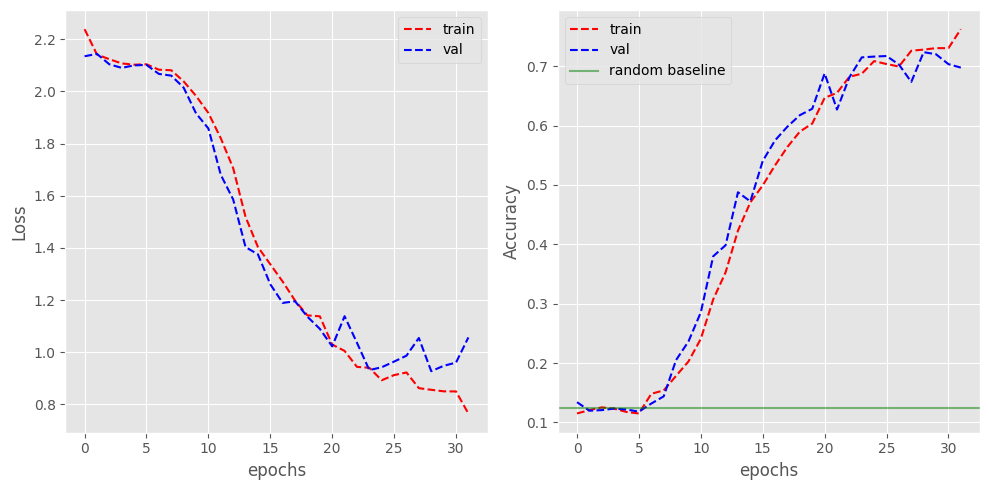

In [12]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['categorical_accuracy'],
    history.history['val_categorical_accuracy'],
    to_file=f'images/{model_name}-LearningCurve.png'
)

## 4.3. Model Performance

Evaluated against test dataset in `./data/test/`

In [13]:
test = dataset.load(dir_test_dataset)
test['Class'] = test['Class'].astype('str')
test_datagen = ImageDataGenerator(data_format='channels_last')
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=dir_test_dataset,
    x_col='ImgPath',
    y_col='Class',
    target_size=(TARGET_IMG_SIZE, TARGET_IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    seed=42
)

Found 3271 validated image filenames belonging to 8 classes.


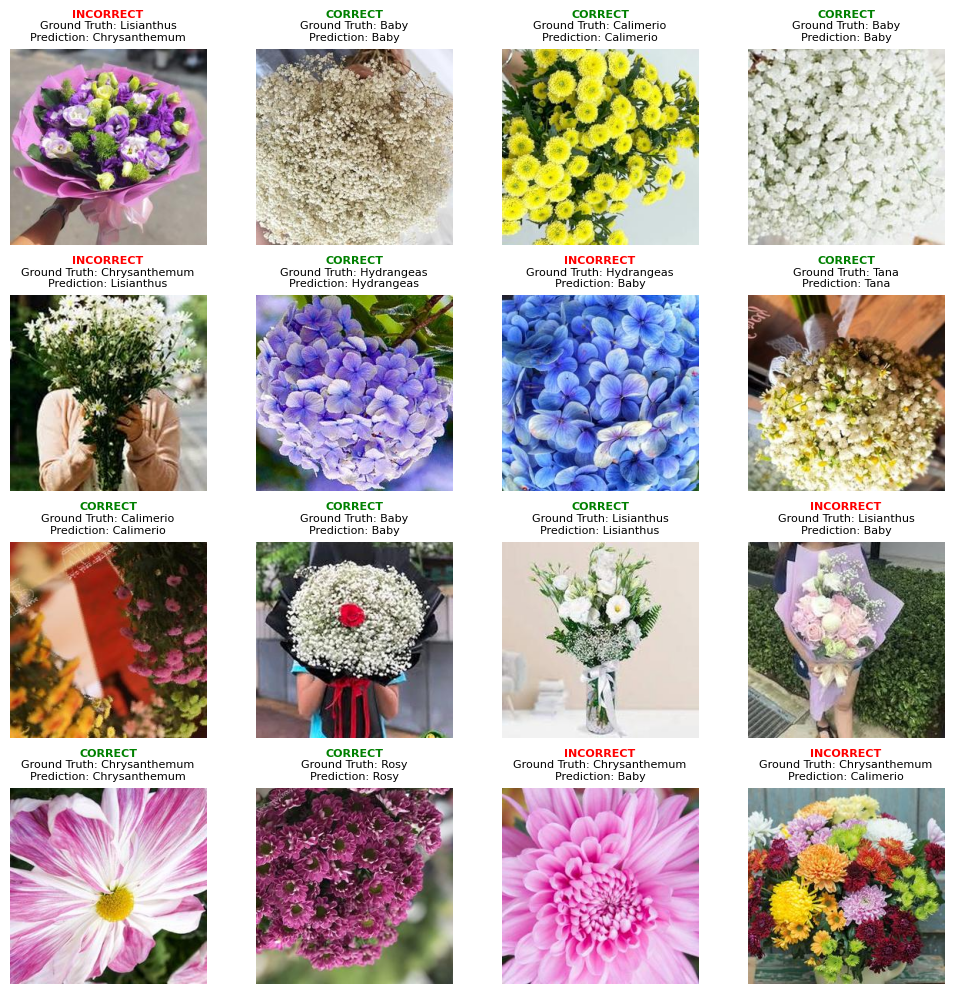

In [14]:
visualize_16predictions(model, test_generator, to_file=f'images/{model_name}-16SamplePredictions.png')

In [15]:
model.evaluate(test_generator)

3271/3271 [==============================] - 18s 6ms/step - loss: 1.0377 - categorical_accuracy: 0.7007


[1.037697196006775, 0.7007031440734863]

**☞ Observation**

We can see that this CNN model has significantly higher performance **(around <span style="color:red">0.7</span> accuracy)** comparing to our baseline ANN model (0.5). By using convolutional layers, our model is now better at capturing most of the important features in our training data while being resistant to noise.

**This will be our final model.**

## 4.4. Model Exporting

In [16]:
model.save(path_model, overwrite = True)

INFO:tensorflow:Assets written to: ../models/clf-cnn\assets


INFO:tensorflow:Assets written to: ../models/clf-cnn\assets
